# GradedLab 1 
## Task 2: Incremental Monte Carlo

In [44]:
# Dependencies

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
from typing import NamedTuple
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

In [45]:
class Params(NamedTuple):
    total_episodes: int 
    map_size: int
    seed: int
    is_slippery: bool
    proba_frozen: float
    gamma: float
    epsilon: float
    learning_rate: float

In [46]:
# Plots
def plot_trajectory_lengths(trajectory_lengths):
    plt.figure(figsize=(10, 5))
    plt.plot(trajectory_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Trajectory Length (Steps)")
    plt.title("Length of Trajectories per Episode")
    plt.show()

def plot_learning_curve(episode_returns):
    plt.figure(figsize=(10, 5))
    cumulative_returns = np.cumsum(episode_returns)
    plt.plot(cumulative_returns)
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Reward")
    plt.title("Learning Curve (Cumulative Reward over Episodes)")
    plt.show()

def plot_value_function(V, params: Params):
    size = params.map_size
    values = np.zeros((size, size))
    for state in range(len(V)):
        row, col = divmod(state, size)
        values[row, col] = V[state]
    
    plt.figure(figsize=(7, 6))  
    plt.imshow(values, cmap='viridis', interpolation='nearest') 
    plt.colorbar(label="State-Value (V)")
    plt.title("State-Value Function (Monte Carlo First-Visit)")
    plt.xlabel("State (Columns)")
    plt.ylabel("State (Rows)")
    
    for i in range(size):
        for j in range(size):
            plt.text(j, i, f"{values[i, j]:.2f}", ha='center', va='center', color="white" if values[i, j] < 0.3 else "black")
    
    plt.show()

In [76]:


def incremental_monte_carlo(params: Params):
    random_map = generate_random_map(size=params.map_size, p=params.proba_frozen)
    env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=params.is_slippery)
    env.reset(seed=params.seed)

    # Initialize value array
    V = np.zeros(env.observation_space.n)
    episode_lengths = []
    episode_returns = []

    for episode in range(params.total_episodes):
        episode_data = epsilon_greedy_policy(env, V, params.epsilon)
        episode_lengths.append(len(episode_data))

        G = 0  # cumulative reward
        visited_states = set()  # Track visited states within this episode

        for t in reversed(range(len(episode_data))):
            state, action, reward = episode_data[t]
            G = reward + params.gamma * G  # Discounted reward

            # First-Visit check
            if state not in visited_states:
                visited_states.add(state)
                V[state] = V[state] + params.learning_rate * (G - V[state])

        episode_returns.append(G)

    return V, episode_lengths, episode_returns

def epsilon_greedy_policy(env, V, epsilon):
    """Generate an episode using epsilon-greedy policy with true exploitation."""
    episode = []
    state, _ = env.reset()
    done = False

    while not done:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Exploration: random action
        else:
            # Exploitation: Choose action leading to the highest-valued next state
            action_values = []
            for action in range(env.action_space.n):
                # Look ahead to estimate the value of taking this action
                next_state, _, _, _, _ = env.step(action)
                action_values.append(V[next_state])

            # Select the action that leads to the highest valued next state
            max_value = np.max(action_values)
            max_actions = [a for a, val in enumerate(action_values) if val == max_value]
            action = np.random.choice(max_actions)  # Randomly among best actions

        # Take action in environment
        next_state, reward, done, _, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state  # Update state for the next step

    return episode

### 5x5 configuration

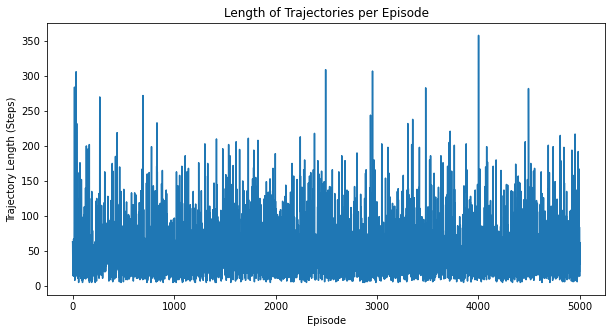

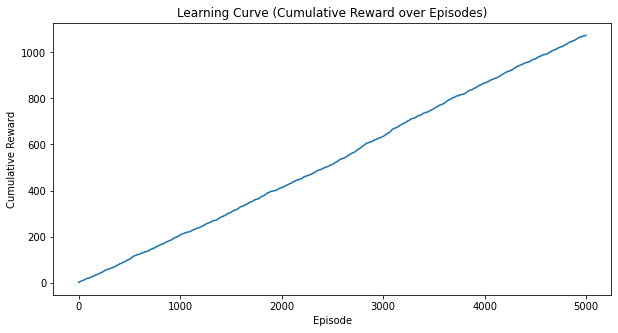

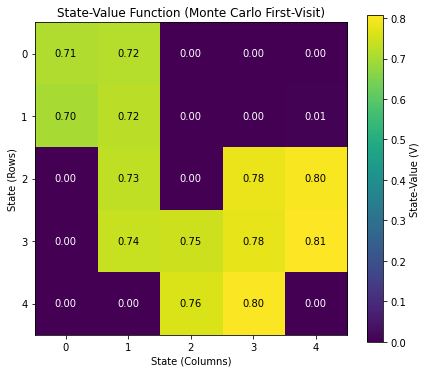

In [51]:
params_5x5 = Params(total_episodes=5000, map_size=5, seed=123, is_slippery=False, proba_frozen=0.9, gamma=0.99, epsilon=0.3, learning_rate=0.8)
V_5x5_incremental, trajectory_lengths_5x5_incremental, episode_returns_5x5_incremental = incremental_monte_carlo(params_5x5)

# Plot results
plot_trajectory_lengths(trajectory_lengths_5x5_incremental)
plot_learning_curve(episode_returns_5x5_incremental)
plot_value_function(V_5x5_incremental, params_5x5)

### 11x11 configuration

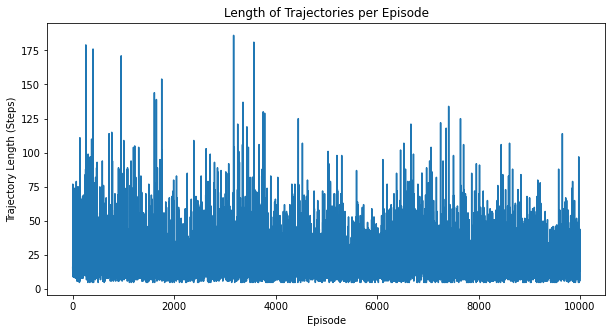

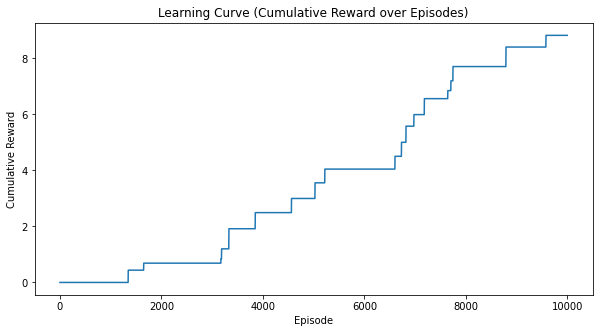

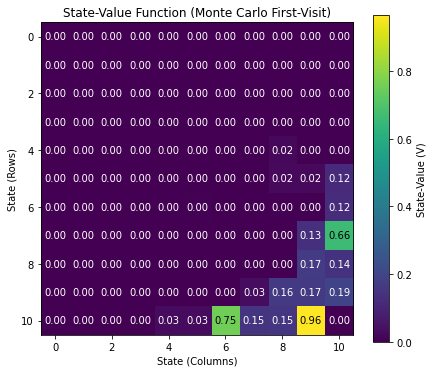

In [110]:
params_11x11 = Params(total_episodes=10000, map_size=11, seed=123, is_slippery=False, proba_frozen=0.9, gamma=0.99, epsilon=0.8, learning_rate=0.8)
V_11x11_incremental, trajectory_lengths_11x11_incremental, episode_returns_11x11_incremental = incremental_monte_carlo(params_11x11)

# Plot results
plot_trajectory_lengths(trajectory_lengths_11x11_incremental)
plot_learning_curve(episode_returns_11x11_incremental)
plot_value_function(V_11x11_incremental, params_11x11)